In [1]:
import mne
import warnings
import matplotlib.pyplot as plt
import os
import numpy as np
from tqdm import tqdm
import pycwt
warnings.filterwarnings('ignore')

In [2]:
def find_common_electrodes(path):
    mdd_electrodes_set = []
    for elem in os.listdir(path):
        data = mne.io.read_raw(path + elem, verbose = False)
        mdd_electrodes_set.append(set(data.ch_names))
    return set.intersection(*mdd_electrodes_set)

In [3]:
kz_mdd = find_common_electrodes('data/kz_clean/mdd/')
kz_health = find_common_electrodes('data/kz_clean/health/')
electrodes_to_use = set.intersection(kz_mdd, kz_health)
print(electrodes_to_use)

{'O2', 'Oz', 'C4', 'Cz', 'P3', 'C3', 'O1', 'T6', 'Fpz', 'F8', 'F4', 'T5', 'Fz', 'T4', 'Fp1', 'Fp2', 'T3', 'Pz', 'P4', 'F3', 'F7'}


# Cut data into 2s/4s patches (without overlapping)

In [4]:
Fs = 500
electrodes_to_use = set.intersection(kz_mdd, kz_health)
window_size = 2 # in seconds

In [5]:
def cut_data(path, path_to_save, window_size = window_size, 
             window_offset = window_size, 
             Fs = Fs, electrodes_to_use = electrodes_to_use):
    for elem in tqdm(os.listdir(path)):
        data = mne.io.read_raw(path + elem, verbose = False)
        
        for ch in data.ch_names:
            if ch not in electrodes_to_use:
                data.drop_channels(ch)
        np_data = data[:][0].T
        
        idx = 1
        offset = 0
        num_of_samples = Fs * window_size
        while np_data[offset : offset + num_of_samples].shape[0] == num_of_samples:
            name = elem.split('.')[0]
            np.save(path_to_save + f'{name}_patch_{idx}.npy', 
                    np_data[offset : offset + num_of_samples])
            offset += window_offset * Fs
            idx += 1

In [6]:
# cut_data('data/kz_clean/health/', 'data_np/kz_clean/health/', window_size = 2)
# cut_data('data/kz_clean/mdd/', 'data_np/kz_clean/mdd/', window_size = 2)

In [7]:
# cut_data('data/kz_clean/health/', 'data_np_4s/kz_clean/health/', window_size = 4)
# cut_data('data/kz_clean/mdd/', 'data_np_4s/kz_clean/mdd/', window_size = 4)

# ToDo  
* baseline feature generation
* wavelet coherence for each patch for each electrode  
* simple run with gnn (working!)

## Computing wavelet coherence significance

In [13]:
signif = np.load('significance_4s_patch.npy')

In [14]:
def compute_wavelet_coh_adj_matrix(path_to_data, path_to_save, significance = signif, Fs = Fs):
    bad_logs = []
    for file in tqdm(os.listdir(path_to_data)):
        res_row = []
        data = np.load(path_to_data + file)
        for i in range(data.shape[1]):
            res_column = []
            for j in range(data.shape[1]):
                
                try:
                    wavelet_coh = pycwt.wct(data[:, i], data[:, j], dt = 1 / Fs, sig = False)[0]
                except:
                    print('bag in')
                    print(path_to_data + file)
                    bad_logs.append(path_to_data + file)
                    break
                    
                significant_points = 0
                for column in range(wavelet_coh.shape[1]):
                    # without last because of last nan elem in significance
                    significant_points += np.sum(wavelet_coh[:-1, column] > significance[:-1])
                    
                normalised_significance = significant_points / \
                            (wavelet_coh.shape[0] * wavelet_coh.shape[1])   
                res_column.append(normalised_significance)
#                 print(res_column)
            res_row.append(res_column)
        name = file.split('.')[0]
        np.save(path_to_save + f'{name}.npy', np.array(res_row))
    return bad_logs

In [15]:
# logs = compute_wavelet_coh_adj_matrix('data_np_4s/kz_clean/health/', 'wavelet_coh_npy/kz_clean/health/')

In [16]:
def compute_wavelet_coh_adj_matrix_parallel(file, significance = signif, Fs = Fs):
    path_to_data = 'data_np_4s/kz_clean/health/'
    path_to_save = 'wavelet_coh_npy/kz_clean/health/'
#     bad_logs = []
    res_row = []
    data = np.load(path_to_data + file)
    for i in range(data.shape[1]):
        res_column = []
        for j in range(data.shape[1]):

            try:
                wavelet_coh = pycwt.wct(data[:, i], data[:, j], dt = 1 / Fs, sig = False)[0]
            except:
                print('bag in')
                print(path_to_data + file)
                with open('wavelet_coh_npy/kz_clean/health/logs.txt', 'a') as f:
                    f.write(path_to_data + file + '\n')
                break

            significant_points = 0
            for column in range(wavelet_coh.shape[1]):
                # without last because of last nan elem in significance
                significant_points += np.sum(wavelet_coh[:-1, column] > significance[:-1])

            normalised_significance = significant_points / \
                        (wavelet_coh.shape[0] * wavelet_coh.shape[1])   
            res_column.append(normalised_significance)
#                 print(res_column)
        res_row.append(res_column)
    name = file.split('.')[0]
    np.save(path_to_save + f'{name}.npy', np.array(res_row))

In [ ]:
# from joblib import Parallel, delayed
# Parallel(n_jobs = -1)(delayed(compute_wavelet_coh_adj_matrix_parallel)(x) \
#                       for x in os.listdir('data_np_4s/kz_clean/health'))


/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

bag in
data_np_4s/kz_clean/health/clean_F136_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_41.npy
bag in
data_np

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

bag in
data_np_4s/kz_clean/health/clean_F126_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_41.npy
bag in
data_np

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


bag in
data_np_4s/kz_clean/health/clean_F134_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_58.npy
bag in
data_np

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

bag in
data_np_4s/kz_clean/health/clean_F134_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_57.npy
bag in
data_np

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

bag in
data_np_4s/kz_clean/health/clean_F117_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_60.npy
bag in
data_np

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

bag in
data_np_4s/kz_clean/health/clean_F135_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_38.npy
bag in
data_np

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

bag in
data_np_4s/kz_clean/health/clean_M157_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_40.npy
bag in
data_np

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


bag in
data_np_4s/kz_clean/health/clean_F137_patch_2.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_2.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_2.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_2.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_2.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_2.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_2.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_2.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_2.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_2.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_2.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_2.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_2.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_2.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_2.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_2.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_2.npy
bag in
data_np_4s/kz_clean/heal

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_F127_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F127_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F127_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F127_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F127_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F127_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_49.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_49.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_49.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_49.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_49.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_49.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_49.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_49.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_49.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_49.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_49.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_M165_patch_10.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_10.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_10.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_10.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_10.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_10.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_21.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_21.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_21.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_21.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_21.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_21.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_21.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_21.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_21.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_21.npy
bag in
data_np_4s/kz_clean/health/clean_F136_patch_21.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


bag in
data_np_4s/kz_clean/health/clean_F138_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_F138_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_F138_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_F138_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_F138_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_F138_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_F138_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_F138_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_F138_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_F138_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_F138_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_F138_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_F138_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_F138_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_F138_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_F138_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_F138_patch_59.npy
bag in
data_np

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


data_np_4s/kz_clean/health/clean_M157_patch_5.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_5.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_5.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_5.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_5.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_5.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_37.npy
bag in
data_np_4s/kz_clean/

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_F121_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_37.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_37.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


data_np_4s/kz_clean/health/clean_F137_patch_76.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_76.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_76.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_76.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_76.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_76.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_45.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_F126_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_F126_patch_40.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_27.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


data_np_4s/kz_clean/health/clean_F137_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_43.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_43.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_43.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_43.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_43.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_43.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_43.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_43.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_43.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_43.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_43.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_F135_patch_25.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_25.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_25.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_25.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_25.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_25.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_51.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_M165_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_F124_patch_57.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


data_np_4s/kz_clean/health/clean_F117_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_33.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_33.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_33.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_33.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_33.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

bag in
data_np_4s/kz_clean/health/clean_M154_patch_62.npy
bag in
data_np_4s/kz_clean/health/clean_M154_patch_62.npy
bag in
data_np_4s/kz_clean/health/clean_M154_patch_62.npy
bag in
data_np_4s/kz_clean/health/clean_M154_patch_62.npy
bag in
data_np_4s/kz_clean/health/clean_M154_patch_62.npy
bag in
data_np_4s/kz_clean/health/clean_M154_patch_62.npy
bag in
data_np_4s/kz_clean/health/clean_M154_patch_62.npy
bag in
data_np_4s/kz_clean/health/clean_M154_patch_62.npy
bag in
data_np_4s/kz_clean/health/clean_M154_patch_62.npy
bag in
data_np_4s/kz_clean/health/clean_M154_patch_62.npy
bag in
data_np_4s/kz_clean/health/clean_M154_patch_62.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_29.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_29.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_29.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_29.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_29.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_29.npy
bag in
data_np

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_F121_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_50.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


data_np_4s/kz_clean/health/clean_M153_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_M153_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_M153_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_M153_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_M153_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_M153_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_M153_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_M153_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_M153_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_M153_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_M153_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_M153_patch_38.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_32.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_32.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_32.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_32.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_32.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


data_np_4s/kz_clean/health/clean_F117_patch_8.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_8.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_8.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_8.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_8.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_8.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_8.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_8.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_8.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_8.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_8.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_8.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_57.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_57.npy
bag in
data_np_4s/kz_clean/health

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_F137_patch_1.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_1.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_1.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_1.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_1.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_1.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_1.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_1.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_1.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_1.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_1.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_1.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_41.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_41.npy
bag in
data_np_4s/kz_clean/health

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_F133_patch_35.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_35.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_35.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_35.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_35.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_35.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_35.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_35.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_35.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_35.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_35.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_35.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_35.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_35.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_35.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_35.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_35.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_M165_patch_47.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_47.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_47.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_47.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_47.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_47.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_47.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_47.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_47.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_47.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_47.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_47.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_33.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_33.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_33.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_33.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_33.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


data_np_4s/kz_clean/health/clean_F134_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_F134_patch_15.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_58.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


data_np_4s/kz_clean/health/clean_M152_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M152_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_50.npy
bag in
data_np_4s/kz_clean/health

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


data_np_4s/kz_clean/health/clean_F125_patch_18.npy
bag in
data_np_4s/kz_clean/health/clean_F125_patch_18.npy
bag in
data_np_4s/kz_clean/health/clean_F125_patch_18.npy
bag in
data_np_4s/kz_clean/health/clean_F125_patch_18.npy
bag in
data_np_4s/kz_clean/health/clean_F125_patch_18.npy
bag in
data_np_4s/kz_clean/health/clean_F125_patch_18.npy
bag in
data_np_4s/kz_clean/health/clean_F125_patch_18.npy
bag in
data_np_4s/kz_clean/health/clean_F125_patch_18.npy
bag in
data_np_4s/kz_clean/health/clean_F125_patch_18.npy
bag in
data_np_4s/kz_clean/health/clean_F125_patch_18.npy
bag in
data_np_4s/kz_clean/health/clean_F125_patch_18.npy
bag in
data_np_4s/kz_clean/health/clean_F125_patch_18.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F133_patch_45.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_F129_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_58.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_F122_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_27.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_56.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_56.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_56.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_56.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_56.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_F117_patch_31.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_31.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_31.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_31.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_31.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_31.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_31.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_31.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_31.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_31.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_31.npy
bag in
data_np_4s/kz_clean/health/clean_F117_patch_31.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_58.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


data_np_4s/kz_clean/health/clean_M118_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_59.npy
bag in
data_np_4s/kz_clean/health/clean_M118_patch_59.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

bag in
data_np_4s/kz_clean/health/clean_F135_patch_11.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_11.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_11.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_11.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_11.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_11.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_11.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_11.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_11.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_11.npy
bag in
data_np_4s/kz_clean/health/clean_F135_patch_11.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_18.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_18.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_18.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_18.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_18.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_18.npy
bag in
data_np

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_F129_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_51.npy
bag in
data_np_4s/kz_clean/health/clean_F129_patch_51.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_M157_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_6.npy
bag in
data_np_4s/kz_clean/health/clean_M157_patch_6.npy
bag in
data_np_4s/kz_clean/health/clea

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


data_np_4s/kz_clean/health/clean_F120_patch_31.npy
bag in
data_np_4s/kz_clean/health/clean_F120_patch_31.npy
bag in
data_np_4s/kz_clean/health/clean_F120_patch_31.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_9.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_9.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_9.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_9.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_9.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_9.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_9.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_9.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_9.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_9.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_9.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_9.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_9.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_9.npy
bag in
data_np_4s/kz_clean/health/c

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


data_np_4s/kz_clean/health/clean_F121_patch_14.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_14.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_14.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_14.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_14.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_14.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_14.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_14.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_14.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_14.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_14.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_14.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_14.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_14.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_14.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_14.npy
bag in
data_np_4s/kz_clean/health/clean_F121_patch_14.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_F128_patch_48.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_48.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_48.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_48.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_48.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_48.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_48.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_48.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_48.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_48.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_48.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_48.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_48.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_48.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_48.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_48.npy
bag in
data_np_4s/kz_clean/health/clean_F128_patch_48.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_F131_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_58.npy
bag in
data_np_4s/kz_clean/health/clean_F131_patch_58.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_F123_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_60.npy
bag in
data_np_4s/kz_clean/health/clean_F123_patch_60.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


bag in
data_np_4s/kz_clean/health/clean_F122_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_50.npy
bag in
data_np_4s/kz_clean/health/clean_F122_patch_50.npy
bag in
data_np

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_F137_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_45.npy
bag in
data_np_4s/kz_clean/health/clean_F137_patch_45.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

data_np_4s/kz_clean/health/clean_M165_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_46.npy
bag in
data_np_4s/kz_clean/health/clean_M165_patch_46.npy
bag in
data_np_4s/kz_

/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/tmp/ipykernel_15193/891190774.py:31: VisibleDeprecationWarning: Creating an ndarray from r

In [97]:
def plot_wcoh(wcoh):
    """don't forget about %matplotlib inline mode"""
    fig, ax = plt.subplots(figsize = (20, 2))
    cwtspec = ax.imshow(wcoh, cmap = 'jet', aspect = 'auto')
    bar = plt.colorbar(cwtspec)
    ax.set_ylim([0, 50])
    plt.show()

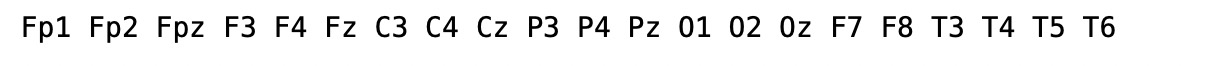

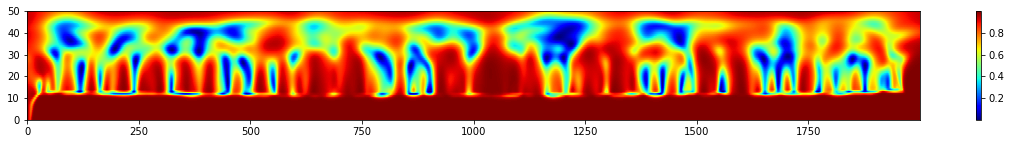

In [98]:
plot_wcoh(wcoh[0])

In [99]:
signif_points = 0
for column in range(wcoh[0].shape[1]):
    signif_points += np.sum(wcoh[0][:-1, column] > significance[:-1])
signif_points / (wcoh[0].shape[0] * wcoh[0].shape[1])

0.6090041322314049

In [101]:
wcoh = pycwt.wct(test_signal[:, 0], test_signal[:, 19], dt = 1 / Fs, normalize = True) 

NOTE: WCT significance loaded from cache.



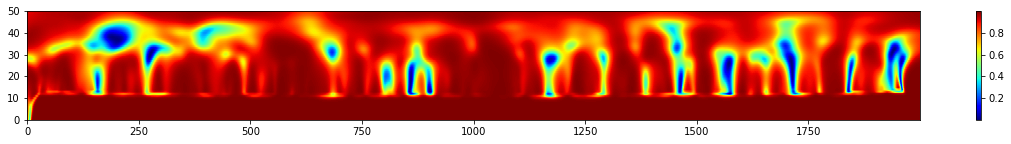

In [102]:
plot_wcoh(wcoh[0])

In [103]:
signif_points = 0
for column in range(wcoh[0].shape[1]):
    signif_points += np.sum(wcoh[0][:-1, column] > significance[:-1])
signif_points / (wcoh[0].shape[0] * wcoh[0].shape[1])

0.8160537190082645

In [104]:
test_signal_mdd = np.load('data_np_4s/kz_clean/mdd/clean_F155_patch_1.npy')

NOTE: WCT significance loaded from cache.



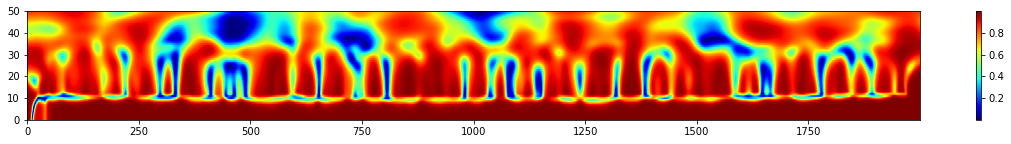

In [105]:
wcoh = pycwt.wct(test_signal_mdd[:, 0], test_signal_mdd[:, 19], dt = 1 / Fs, normalize = True) 
plot_wcoh(wcoh[0])

In [106]:
signif_points = 0
for column in range(wcoh[0].shape[1]):
    signif_points += np.sum(wcoh[0][:-1, column] > significance[:-1])
signif_points / (wcoh[0].shape[0] * wcoh[0].shape[1])

0.7348801652892561